# Deep Learning
## Summative assessment
### Coursework 2

#### Instructions

This coursework is released on **Wednesday 21st February 9.00** and is due by **Wednesday 6th March 23.59**. It is worth **40%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 10 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a deep learning model for a classification task using multimodal data.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file) and a PDF submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF copy of your executed notebook, in case the .ipynb file is corrupted for some reason. 

Upload a zip file containing your notebook and separate PDF file(s) to Coursera by the deadline above.

In [1]:
# You will need the following imports for this assessment. You can make additional imports when you need them

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.keras.layers import (Layer, Input, Dense, GRU, Embedding, Conv2D, BatchNormalization, Activation, GlobalMaxPooling2D)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# You will need access to a GPU for this coursework

tf.config.list_physical_devices('GPU')

[]

#### The CLEVR Dataset

This assessment makes use of the [CLEVR Dataset](https://cs.stanford.edu/people/jcjohns/clevr/). This dataset is a visual question answering dataset, and consists of images with corresponding text questions and answers about the image.  

* Johnson, J., Hariharan, B., van der Maaten, L., Li, F.-F., Zitnick, C. L. & Girshick, R. (2016), "CLEVR: A Diagnostic Dataset for Compositional Language and Elementary Visual Reasoning", *IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, 1988-1997.

The original dataset consists of a training set of 70,000 images and 699,989 questions, a validation set of 15,000 images and 149,991 questions, and a test set of 15,000 images and 14,988 questions. In this coursework you will work with a subset of the training and validation splits, which have been preprocessed and prepared for you. 

The data is stored in TFRecord format, which is a data format that is efficient for TensorFlow to work with. You can read about the TFRecord format [here](https://www.tensorflow.org/tutorials/load_data/tfrecord) if you are interested, but there is no need to find out about TFRecord for this assessment. The code to read in the TFRecord data to Dataset objects is provided for you below.

In [3]:
train_ds = tf.data.TFRecordDataset([os.path.join('data', 'train', f) 
                                    for f in os.listdir(os.path.join('data', 'train')) if f.endswith('tfrecords')])
val_ds = tf.data.TFRecordDataset([os.path.join('data', 'val', f) 
                                    for f in os.listdir(os.path.join('data', 'val')) if f.endswith('tfrecords')])

In [4]:
# The following helper function will parse the TFRecord files to return a dictionary of TensorFlow objects

def parse_function(example_proto):
    features = {
        "image": tf.io.FixedLenFeature((), tf.string),
        "question": tf.io.VarLenFeature(dtype=tf.string),
        "answer": tf.io.VarLenFeature(dtype=tf.string)
    }
    parsed_features = tf.io.parse_single_example(serialized=example_proto, features=features)
    parsed_features["question"] = tf.sparse.to_dense(parsed_features["question"])
    parsed_features["answer"] = tf.sparse.to_dense(parsed_features["answer"])
    image = tf.io.decode_raw(parsed_features["image"], tf.int32)
    image = tf.reshape(image, [224, 224, 3])
    parsed_features["image"] = image
    return parsed_features

In [5]:
train_ds = train_ds.map(parse_function)
val_ds = val_ds.map(parse_function)

In [6]:
train_ds.element_spec

{'answer': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'question': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'image': TensorSpec(shape=(224, 224, 3), dtype=tf.int32, name=None)}

Your task in this assessment is to develop a deep learning model to predict the answer for a given question about an image.

You will need to implement special customised layers and a sophisticated model architecture, making use of both CNN and RNN models. You will process the data, train and evaluate the specified model, and then write a proposal for your own modified architecture.

### Question 1 (Total 15 marks)

The training and validation datasets both return dictionaries with keys `"image"`, `"question"` and `"answer"`. For each image, there are multiple questions and answers. The question and answer entries in the dictionary are both lists of strings of the same length, with aligned questions and answers for the given image. The image entry is a 224x224x3 integer Tensor. These images have been resized from the original size of 480x320, so they appear slightly stretched (this can be ignored). 

a) Inspect the contents of the dataset by displaying at least one image and it's corresponding questions and answers.

**(3 marks)**

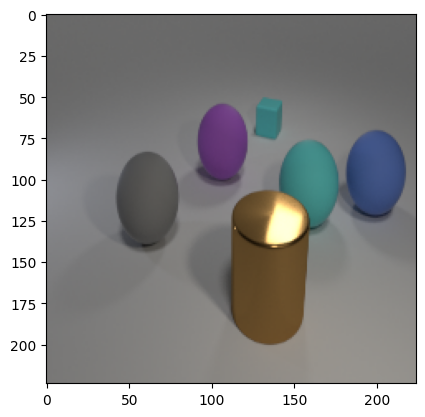

There is a purple object that is the same size as the blue matte sphere; what is its shape?
Q: There is a purple object that is the same size as the blue matte sphere; what is its shape?
A: sphere
Q: What number of other things are there of the same color as the cube?
A: 1
Q: What is the color of the object that is in front of the big gray rubber ball?
A: brown
Q: How many other things are there of the same material as the gray thing?
A: 4
Q: Are there more big brown objects right of the gray thing than tiny things in front of the big cyan thing?
A: yes
Q: What number of things are on the left side of the brown metallic cylinder?
A: 2
Q: Is the large blue thing made of the same material as the large thing that is in front of the large gray rubber object?
A: no
Q: Are there any other things that have the same shape as the small matte object?
A: no
Q: Do the cube and the brown cylinder have the same material?
A: no
Q: There is a large object behind the large blue rubber ball; is there a 

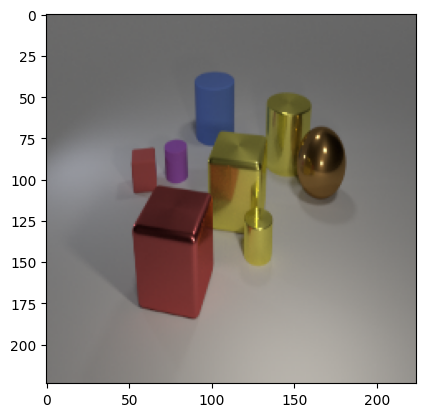

Do the tiny shiny cylinder and the big shiny cylinder have the same color?
Q: Do the tiny shiny cylinder and the big shiny cylinder have the same color?
A: yes
Q: There is a purple cylinder that is made of the same material as the tiny block; what is its size?
A: small
Q: What is the color of the large object that is both right of the yellow shiny cube and behind the brown metallic thing?
A: yellow
Q: How many blue matte cylinders are the same size as the shiny ball?
A: 1
Q: What is the size of the other metallic cylinder that is the same color as the big shiny cylinder?
A: small
Q: There is a cube that is both on the right side of the small red thing and to the left of the blue rubber object; how big is it?
A: large
Q: There is a small rubber thing behind the small thing left of the small purple rubber object; what number of yellow shiny objects are on the left side of it?
A: 0
Q: Are there any small metallic cylinders of the same color as the big metallic cylinder?
A: yes
Q: What is 

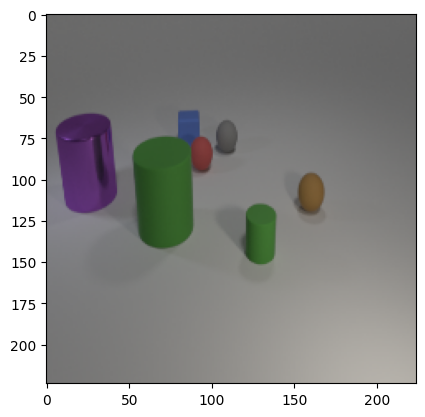

How many gray things have the same shape as the large green thing?
Q: How many gray things have the same shape as the large green thing?
A: 0
Q: What number of objects are there?
A: 7
Q: There is a cylinder that is to the left of the small blue matte cube and right of the purple shiny object; what is its size?
A: large
Q: What shape is the brown object that is the same size as the blue block?
A: sphere
Q: There is a green object that is on the right side of the tiny gray matte sphere; is there a large green matte thing that is to the right of it?
A: no
Q: What is the color of the tiny rubber object that is the same shape as the purple metal thing?
A: green
Q: There is a matte object that is to the left of the tiny blue rubber object; is it the same color as the large metal cylinder?
A: no
Q: How many objects are matte spheres in front of the large metallic object or tiny green objects?
A: 2
Q: What material is the large object that is in front of the matte ball right of the tiny matte 

In [7]:
# Display the first image and question from the training set
for data in train_ds.take(3):
    plt.imshow(data['image'].numpy())
    plt.show()
    print(data['question'].numpy()[0].decode('utf-8'))
    
    for question, answer in zip(data['question'].numpy().astype(str), data['answer'].numpy().astype(str)):
        print(f"Q: {question}")
        print(f"A: {answer}")

b) The training and validation Datasets should be processed as follows:

* The image pixel values should be scaled to the interval $[0, 1]$.
* The answers should be (sparse) encoded as integer labels. You will need to compute the total number of distinct answers to do this.
* The questions should be tokenized and represented as a sequence of integer tokens. The questions should be split on whitespace and standardized by lowercasing and removing punctuation. 
* A single question-answer pair should be uniformly sampled from the available questions and answers for each image (so each image should appear exactly once per epoch with a single question-answer pair).
* The inputs to the model will be the question and the image. The targets will be the answer. Process the Datasets so that they return a tuple of 2 elements corresponding to inputs and targets.
* Shuffle the training Dataset, and batch both Datasets with batch size 64.

Print out the number of distinct answer labels, as well as the number of tokens in the vocabulary computed from the questions.

Print out the element_spec of one of the Datasets after processing. 

**(12 marks)**

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Assuming `parse_function` is defined as in your provided code snippet.

# Helper function to scale images
def scale_images(features):
    features['image'] = tf.cast(features['image'], tf.float32) / 255.0
    return features

# Function to tokenize questions
def tokenize_questions(questions, vocab_size=10000, output_sequence_length=20):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=output_sequence_length)
    
    vectorize_layer.adapt(questions)
    return vectorize_layer, vectorize_layer.get_vocabulary()

# Function to prepare datasets
def prepare_dataset(dataset, vectorize_layer, answer_to_index, is_training=True):
    def sample_and_process(features):
        features = scale_images(features)
        idx = tf.random.uniform(shape=[], maxval=tf.shape(features['question'])[0], dtype=tf.int32)
        question = tf.gather(features['question'], idx)
        answer = tf.gather(features['answer'], idx)
        
        question = vectorize_layer(question)
        answer = answer_to_index.lookup(answer)
        
        inputs = {'image': features['image'], 'question': question}
        return inputs, answer
    
    dataset = dataset.map(sample_and_process)
    if is_training:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(64)
    return dataset

# Collect all questions and answers to build vocabularies
all_questions = []
all_answers = set()
for features in train_ds.concatenate(val_ds):
    all_questions.extend([q.numpy().decode('utf-8') for q in features['question']])
    all_answers.update([a.numpy().decode('utf-8') for a in features['answer']])

# Tokenize questions and create a question vocabulary
vectorize_layer, question_vocab = tokenize_questions(all_questions)

# Create a mapping for answers to integers
answers = list(all_answers)
answer_to_index = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=answers,
        values=tf.range(len(answers), dtype=tf.int64)),
    default_value=-1)

# Prepare datasets
train_ds = prepare_dataset(train_ds, vectorize_layer, answer_to_index, is_training=True)
val_ds = prepare_dataset(val_ds, vectorize_layer, answer_to_index, is_training=False)

print(f"Number of distinct answer labels: {len(answers)}")
print(f"Number of tokens in the question vocabulary: {len(question_vocab)}")

# Print the element_spec of the training dataset
print(train_ds.element_spec)


Number of distinct answer labels: 28
Number of tokens in the question vocabulary: 82
({'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'question': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))


### Question 2 (Total 35 marks)

The model that you will implement for the visual question answering task was first proposed in the paper

* Perez, E., Strub, F., de Vries, H. & Courville, A. (2018), "FiLM: visual reasoning with a general conditioning layer", in _Proceedings of the Thirty-Second AAAI Conference on Artificial Intelligence_, New Orleans, Louisiana, USA.

The main idea is the introduction of a specialised layer called a FiLM layer (Feature-wise Linear Modulation). The purpose of this layer is to modify the predictions that are made by a CNN prediction model (the central stack coloured in brown in the figure below). The CNN prediction model takes the image as input, and outputs a categorical distribution over the set of possible answers.

The FiLM layer uses information stored in a vector embedding (which comes from the question text) to modify the post-activations of the CNN prediction model. This vector embedding is produced by a gated recurrent unit (GRU) network (referred to in the original paper as the FiLM generator) as the final hidden layer representation after processing the input question. This vector embedding is also referred to as the conditioning signal.

The overall model architecture is shown in the figure below:



![model archi](figures/model.png)



The question is tokenized, and learned embeddings are processed sequentially by the GRU network/FiLM generator. There are potentially multiple FiLM layers within the CNN prediction model. Each FiLM layer uses the GRU embedding $\mathbf{q}$ (the conditioning signal) to modify the output of a convolutional layer within the CNN prediction model, as described in part c).

a) Implement the FiLM generator as a 2-layer stacked GRU network, using an embedding dimension of 64, and 128 neurons for both of the layers of the GRU. The network should output the final 128-dimensional embedding. Print the model summary.

**(3 marks)**

In [18]:
def build_film_generator(vocab_size, embedding_dim=64, gru_units=128, input_shape=(None,)):
    inputs = tf.keras.Input(shape=input_shape, dtype=tf.int32)
    
    # Embedding layer
    x = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    
    # 2-layer stacked GRU
    x = tf.keras.layers.GRU(gru_units, return_sequences=True)(x)
    x = tf.keras.layers.GRU(gru_units)(x)  # Only return the final state
    
    # Create the Keras model instance
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

# Assuming the vocabulary size is known (replace with actual size)
vocab_size = 82  # Example vocabulary size

# Build the model
film_generator = build_film_generator(vocab_size)

# Print the model summary
film_generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          5248      
                                                                 
 gru_2 (GRU)                 (None, None, 128)         74496     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
Total params: 178816 (698.50 KB)
Trainable params: 178816 (698.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


b) The first block of the CNN prediction model is a feature extractor CNN which does not make use of the conditioning signal $\mathbf{q}$ from the GRU network. This block takes the image as input, and passes it through two sub-blocks, each consisting of the following layers:

* A 2D convolutional layer with 128 filters, a 4x4 kernel, 2x2 strides, 'SAME' padding, and no activation function
* A batch normalisation layer
* An element-wise ReLU activation

Implement the feature extractor CNN and print the model summary.

**(2 marks)**

In [19]:
from tensorflow.keras import layers

def build_feature_extractor(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First sub-block
    x = layers.Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='SAME')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second sub-block
    x = layers.Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='SAME')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Create the Keras model instance
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

# Instantiate the feature extractor CNN model
feature_extractor_cnn = build_feature_extractor()

# Print the model summary
feature_extractor_cnn.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     6272      
                                                                 
 batch_normalization_3 (Bat  (None, 112, 112, 128)     512       
 chNormalization)                                                
                                                                 
 re_lu_2 (ReLU)              (None, 112, 112, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       262272    
                                                                 
 batch_normalization_4 (Bat  (None, 56, 56, 128)       512       
 chNormalization)                                          

c) Implement a custom layer class for the FiLM layer as described below. This class should subclass the base `Layer` class in the `tensorflow.keras.layers` module. 

This layer will need to take two inputs when it is called: the conditioning signal $\mathbf{q}$, as well as the previous convolutional layer output $\mathbf{h}$. 

The FiLM layer passes the conditioning signal $\mathbf{q}$ output by the GRU FiLM generator through a linear layer (dense layer with no activation function) to produce $\gamma$ and $\beta$:

$$
\gamma = \textrm{Linear}(\mathbf{q}) \quad\quad \beta = \textrm{Linear}(\mathbf{q}).
$$

Both $\gamma$ and $\beta$ are vectors, with length equal to the number of feature maps (or channels) in the output of a convolutional layer $\mathbf{h}$. These post-activations are then modulated via the feature-wise affine transformation:

$$
\textrm{FiLM}(\mathbf{h} | \gamma, \beta)_{h, w, c} = \gamma_c \mathbf{h}_{h, w, c} + \beta_c,
$$
where the subscripts $h, w, c$ index the height, width and channel dimensions respectively.

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(10 marks)**

In [20]:
class FiLMLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FiLMLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape[0] is the shape of conditioning signal q: (batch_size, q_dimension)
        # input_shape[1] is the shape of the convolutional layer output h: (batch_size, height, width, channels)
        channels = input_shape[1][-1]
        
        # Define the dense layers to create gamma and beta
        self.dense_gamma = tf.keras.layers.Dense(channels, use_bias=False)
        self.dense_beta = tf.keras.layers.Dense(channels, use_bias=False)

    def call(self, inputs):
        # Unpack the inputs, conditioning signal q and previous conv layer output h
        q, h = inputs
        
        # Pass the conditioning signal q through the dense layers to get gamma and beta
        gamma = self.dense_gamma(q)
        beta = self.dense_beta(q)
        
        # Apply the FiLM modulation to the convolutional layer output h
        # Expand gamma and beta to match the shape of h for broadcasting
        gamma = tf.expand_dims(tf.expand_dims(gamma, 1), 1)
        beta = tf.expand_dims(tf.expand_dims(beta, 1), 1)
        
        # Apply the feature-wise affine transformation
        return gamma * h + beta

# Assume q_dimension is the length of the conditioning signal vector
# and h_shape is the shape of the convolutional layer output
q_dimension = 128
h_shape = (None, 56, 56, 128)  # Example shape

# Create dummy data to test the FiLM layer
batch_size = 10
dummy_q = tf.random.normal((batch_size, q_dimension))
dummy_h = tf.random.normal((batch_size,) + h_shape[1:])

# Create an instance of the FiLM layer
film_layer = FiLMLayer()

# Test the custom layer
film_output = film_layer([dummy_q, dummy_h])
print(f"FiLM layer input shapes: {dummy_q.shape}, {dummy_h.shape}")
print(f"FiLM layer output shape: {film_output.shape}")

FiLM layer input shapes: (10, 128), (10, 56, 56, 128)
FiLM layer output shape: (10, 56, 56, 128)


d) The second main block of the CNN network consists of a number of ResBlocks. Each ResBlock consists of the following layers:

![ResBlock](figures/resblock.png)


* A 1x1 convolutional layer with 128 channels and ReLU activation function
* A 3x3 convolutional layer with 128 channels and no activation function
* A BatchNormalization layer, where the usual $\gamma$ and $\beta$ parameters are not used
* a FiLM layer, that also uses the conditioning signal $\mathbf{q}$ from the GRU network
* An elementwise ReLU activation function
* The output is then added to the output of the first convolutional layer

Each convolutional layer uses 'SAME' padding.

Implement the ResBlock as another custom layer. Similar to the FiLM layer, this layer will also need to take two inputs when it is called: the conditioning signal $\mathbf{q}$, as well as the previous convolutional layer output $\mathbf{h}$. 

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(8 marks)**

In [21]:
class ResBlockLayer(tf.keras.layers.Layer):
    def __init__(self, channels=128, **kwargs):
        super(ResBlockLayer, self).__init__(**kwargs)
        self.channels = channels

    def build(self, input_shape):
        # Define the 1x1 convolutional layer with ReLU activation
        self.conv1 = tf.keras.layers.Conv2D(self.channels, kernel_size=(1, 1), padding='SAME', activation='relu')
        
        # Define the 3x3 convolutional layer with no activation
        self.conv2 = tf.keras.layers.Conv2D(self.channels, kernel_size=(3, 3), padding='SAME')
        
        # BatchNormalization layer without γ and β, which will be provided by the FiLM layer
        self.bn = tf.keras.layers.BatchNormalization(scale=False, center=False)
        
        # Initialize the FiLM layer
        self.film_layer = FiLMLayer()
        


    def call(self, inputs):
        # Unpack the inputs, conditioning signal q and previous conv layer output h
        q, h = inputs
        
        # Apply 1x1 conv with ReLU activation
        conv1_output = self.conv1(h)
        
        # Apply 3x3 conv without activation
        conv2_output = self.conv2(conv1_output)
        
        # Apply batch normalization
        bn_output = self.bn(conv2_output)
        
        # Apply FiLM layer using the conditioning signal q and the output of the batch normalization
        film_output = self.film_layer([q, bn_output])
        
        # Apply ReLU activation function
        relu_output = tf.nn.relu(film_output)
        
        # Elementwise addition with the output of the first convolutional layer
        res_output = relu_output + conv1_output
        
        return res_output


In [22]:
# Dummy inputs
dummy_q = tf.random.normal((batch_size, q_dimension))
dummy_h = tf.random.normal((batch_size,) + h_shape[1:])

# Create an instance of the ResBlock layer
resblock_layer = ResBlockLayer()

# Test the custom layer
resblock_output = resblock_layer([dummy_q, dummy_h])
print(resblock_output.shape)


(10, 56, 56, 128)


e) At several points in the model, two coordinate feature maps will be added to the output of a convolutional layer. This operation will be applied before each ResBlock and the classifier component of the CNN prediction model. 

These two feature maps indicate relative $x$ and $y$ spatial position, and are each scaled from $-1$ to $1$ across the height and width dimensions. These two feature maps are concatenated as two extra channels to the convolutional layer output.

Implement this operation as another custom layer class called `AddSpatialCoordinates`. The layer should be able to accept input Tensors with arbitrary height, width and channel dimensions. This custom layer will not have any trainable variables.

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(7 marks)**

In [27]:
class AddSpatialCoordinates(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AddSpatialCoordinates, self).__init__(**kwargs)

    def call(self, input_tensor):
        # Get the dynamic shape of the input tensor
        batch_size, height, width, channels = tf.shape(input_tensor)[0], tf.shape(input_tensor)[1], tf.shape(input_tensor)[2], tf.shape(input_tensor)[3]
        
        # Create coordinate feature maps for x and y
        x_map = tf.linspace(-1.0, 1.0, width)
        y_map = tf.linspace(-1.0, 1.0, height)
        
        # Tile and expand dimensions to match input_tensor shape
        x_map = tf.tile(x_map[tf.newaxis, tf.newaxis, :, tf.newaxis], [batch_size, height, 1, 1])
        y_map = tf.tile(y_map[tf.newaxis, :, tf.newaxis, tf.newaxis], [batch_size, 1, width, 1])
        
        # Concatenate the coordinate feature maps to the input tensor
        output_tensor = tf.concat([input_tensor, x_map, y_map], axis=-1)
        return output_tensor

    def compute_output_shape(self, input_shape):
        # Output shape will have two more channels than the input shape
        return (input_shape[0], input_shape[1], input_shape[2], input_shape[3] + 2)


In [28]:
# Create dummy data to test the AddSpatialCoordinates layer
batch_size = 10
height, width, channels = 56, 56, 128  # Example dimensions
dummy_input = tf.random.normal((batch_size, height, width, channels))

# Create an instance of the AddSpatialCoordinates layer
add_spatial_coordinates_layer = AddSpatialCoordinates()

# Test the custom layer
output_with_coordinates = add_spatial_coordinates_layer(dummy_input)
print(output_with_coordinates.shape)


(10, 56, 56, 130)


f) The final main block of the CNN network is a classifier block. This block consists of the following layers:

* 1x1 convolution with 512 output channels, ReLU activation, and 'SAME' padding
* Global max pooling across height and width dimensions
* Dense layer with 512 neurons and ReLU activation
* Final Dense layer with $n_c$ neurons and softmax activation, where $n_c$ is the number of output labels

Once you have implemented the classifier, you should bring all components together to build the complete model. This model consists of the following:

* GRU FiLM generator as defined in part a) that processes the sequence of question tokens and outputs an embedding $\mathbf{q}$ of dimension 128
* Feature extractor block as defined in part b) that processes the input image
* The output of the feature extractor should then be extended with spatial coordinate feature maps by passing it through your `AddSpatialCoordinates` layer
* This should be followed by just one ResBlock custom layer, that takes in two inputs: the output from the previous `AddSpatialCoordinates` layer and the question embedding $\mathbf{q}$. We will only use one ResBlock due to computational limitations
* The output of the ResBlock should then also be extended with spatial coordinate feature maps by passing it through your `AddSpatialCoordinates` layer
* The output from the previous `AddSpatialCoordinates` layer should then be sent through the classifier block to obtain the final output prediction

Implement the complete model according to the above spec, and print the model summary.

**(5 marks)**

In [35]:
class ClassifierBlock(tf.keras.layers.Layer):
    def __init__(self, num_classes, **kwargs):
        super(ClassifierBlock, self).__init__(**kwargs)
        self.num_classes = num_classes

    def build(self, input_shape):
        # 1x1 Convolution
        self.conv1x1 = tf.keras.layers.Conv2D(512, (1, 1), padding='SAME', activation='relu')
        # Global Max Pooling
        self.global_max_pool = tf.keras.layers.GlobalMaxPooling2D()
        # Dense layer
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        # Final Dense layer with softmax activation
        self.dense_final = tf.keras.layers.Dense(self.num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1x1(inputs)
        x = self.global_max_pool(x)
        x = self.dense1(x)
        return self.dense_final(x)

# Instantiate the layers and blocks
vocab_size = len(question_vocab)  # Replace with the actual size of your question vocabulary
gru_film_generator = build_film_generator(vocab_size=vocab_size)
feature_extractor_cnn = build_feature_extractor(input_shape=(224, 224, 3))
add_spatial_coordinates_layer1 = AddSpatialCoordinates()
resblock_layer = ResBlockLayer()
add_spatial_coordinates_layer2 = AddSpatialCoordinates()

# Assume num_classes is the number of distinct answer labels in your dataset
num_classes = len(answers)  # Replace with the actual number
classifier_block = ClassifierBlock(num_classes=num_classes)

# Define the functional model
def build_complete_model(question_vocab_size, image_shape=(224, 224, 3), num_classes=num_classes):
    # Inputs with specified names that match the dataset keys
    image_input = tf.keras.Input(shape=image_shape, name='image')
    question_input = tf.keras.Input(shape=(None,), dtype=tf.int32, name='question')

    # GRU FiLM generator
    q_embedding = gru_film_generator(question_input)

    # Feature extractor CNN
    cnn_features = feature_extractor_cnn(image_input)

    # Add spatial coordinates
    cnn_features_with_coords = add_spatial_coordinates_layer1(cnn_features)

    # ResBlock with FiLM
    resblock_output = resblock_layer([q_embedding, cnn_features_with_coords])

    # Add spatial coordinates again
    resblock_output_with_coords = add_spatial_coordinates_layer2(resblock_output)

    # Classifier block
    predictions = classifier_block(resblock_output_with_coords)

    # Build the model
    model = tf.keras.Model(inputs=[image_input, question_input], outputs=predictions)

    return model

# Build and summarize the complete model
complete_model = build_complete_model(question_vocab_size=vocab_size, num_classes=num_classes)
complete_model.summary()


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 question (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 model_12 (Functional)       (None, 56, 56, 128)          269568    ['image[0][0]']               
                                                                                                  
 model_11 (Functional)       (None, 128)                  178816    ['question[0][0]']            
                                                                                           

### Question 3 (Total 30 marks)

a) You should now train your model from question 2 using a cross entropy loss function. Train the model for 20 epochs, with an Adam optimizer with learning rate 3e-4. You should track model performance on the validation set, including the accuracy. 

Your code should be structured to account for restarting broken training runs. You will need to save your model every epoch, and save all of the model's training and validation performance up to that point (a convenient method is to use the `CSVLogger` callback). In the case of a broken training run, the required data should be loaded, and the training run resumed from the last saved checkpoint. You do not need to use early stopping in the training run.

When training has completed, compute and print the final evaluation of your model on the validation set.

_NB: The model would need to be larger and trained for longer to achieve good performance on this task. The model and training have been scaled down to accommodate infrastructure limitations on the Coursera platform. You should implement the architecture as specified in this assessment, but you can train the model for longer if you wish. The performance of the resulting model is **not** part of the marking criteria._

**(15 marks)**

In [38]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam

# Define paths for the checkpoint and logs
checkpoint_path = "data/model_checkpoint.h5"  # Replace with your desired checkpoint path
log_path = "data/training_log.csv"  # Replace with your desired log path

# Compile the model
complete_model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if your labels are integers
    metrics=['accuracy']
)

# Callback for saving the model after each epoch
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False
)

# Callback for logging the training history
csv_logger = CSVLogger(log_path, append=True)

# Check if there is a previous checkpoint to resume training
if os.path.exists(checkpoint_path):
    print("Checkpoint found, loading weights.")
    complete_model.load_weights(checkpoint_path)

# Check if there is a previous log to resume logging
if not os.path.exists(log_path):
    # Create a new CSVLogger if no log exists
    csv_logger = CSVLogger(log_path, append=False)
else:
    # Append to the existing log
    csv_logger = CSVLogger(log_path, append=True)

# Train the model
history = complete_model.fit(
    train_ds,  # Assuming train_ds is correctly formatted
    epochs=20,
    validation_data=val_ds,  # Assuming val_ds is correctly formatted
    callbacks=[model_checkpoint_callback, csv_logger]
)

# Evaluate the model on the validation set
final_evaluation = complete_model.evaluate(val_ds)  # Replace with your validation dataset
print("Final evaluation on the validation set:", final_evaluation)


Epoch 1/20
234/234 [==============================] - 996s 4s/step - loss: 1.5763 - accuracy: 0.3354 - val_loss: 1.5359 - val_accuracy: 0.3611
Epoch 2/20
234/234 [==============================] - 878s 4s/step - loss: 1.3723 - accuracy: 0.3803 - val_loss: 1.3255 - val_accuracy: 0.3768
Epoch 3/20
234/234 [==============================] - 5126s 22s/step - loss: 1.2799 - accuracy: 0.3965 - val_loss: 1.2810 - val_accuracy: 0.3936
Epoch 4/20
234/234 [==============================] - 861s 4s/step - loss: 1.2199 - accuracy: 0.4052 - val_loss: 1.2161 - val_accuracy: 0.4101
Epoch 5/20
234/234 [==============================] - 969s 4s/step - loss: 1.1932 - accuracy: 0.4109 - val_loss: 1.1964 - val_accuracy: 0.3893
Epoch 6/20
234/234 [==============================] - 895s 4s/step - loss: 1.1842 - accuracy: 0.4058 - val_loss: 1.1886 - val_accuracy: 0.4029
Epoch 7/20
234/234 [==============================] - 937s 4s/step - loss: 1.1745 - accuracy: 0.4158 - val_loss: 1.1646 - val_accuracy: 0.41

b) Plot the loss and accuracy over the course of training on the training and validation sets.

Select at least one sample image and question from the validation set, and compute the model predictions. Display the image, question, ground truth answer and model predictive distribution over the set of answers.

**(7 marks)**

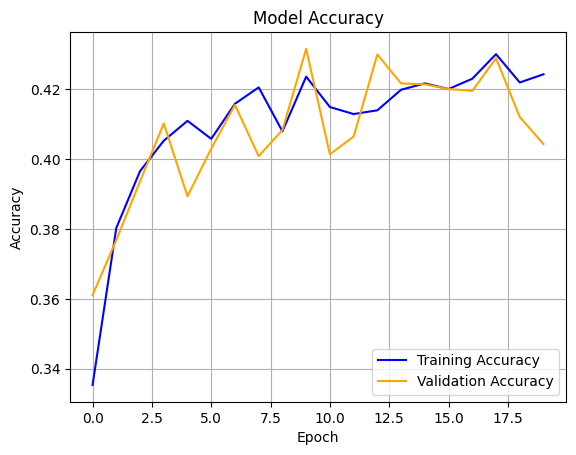

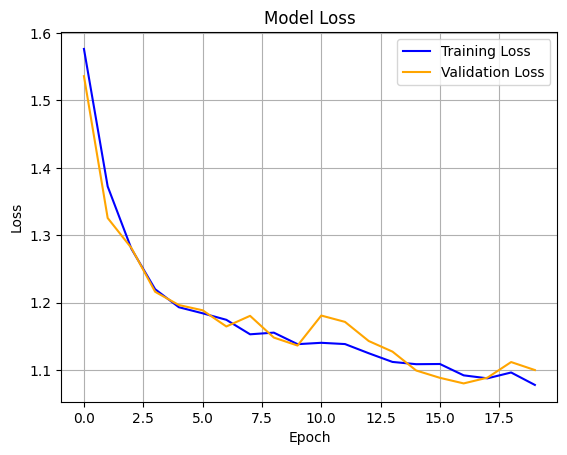

In [50]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


2/2 [==============================] - 1s 388ms/step


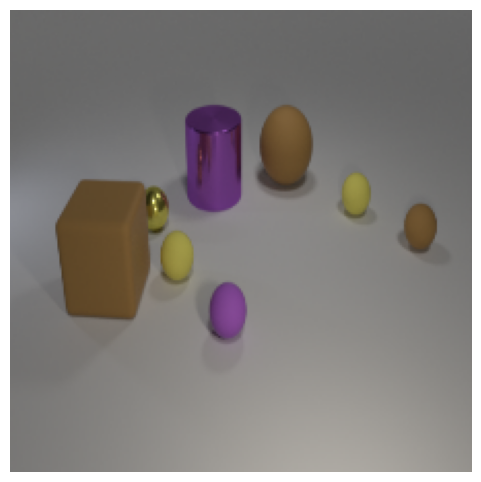

Question: is there any other thing that has the same size as the shiny cylinder
True answer: yes
Predicted answer: yes
Prediction distribution: [9.4549350e-06 1.1033974e-06 4.2522687e-01 3.6378704e-08 6.2828030e-07
 6.6329409e-10 2.7070024e-07 3.7239992e-11 6.3849819e-07 7.6549514e-07
 9.0046497e-06 1.9725883e-06 6.0416075e-14 4.9626644e-13 1.1867601e-06
 2.3760761e-06 2.7580584e-06 1.0799547e-06 6.5712638e-06 8.1358294e-08
 6.8457002e-06 7.3365760e-07 4.4753360e-06 1.4487987e-06 2.7612875e-06
 2.0101277e-11 5.7471502e-01 3.8971602e-06]


In [54]:
# Function to decode predictions
def decode_predictions(predictions, answers):
    # Get the index of the highest probability
    predicted_index = np.argmax(predictions)
    # Return the answer corresponding to the predicted index
    return answers[predicted_index]

# Function to visualize the data
def display_sample(sample, answers, model):
    # Unpack the sample
    (inputs, true_answer_index) = sample
    image = inputs['image'][0]  # Assuming batch size of 1
    question = inputs['question'][0]
    
    # Predict the answer
    predictions = model.predict(inputs)
    predicted_answer = decode_predictions(predictions[0], answers)
    
    # Decode the true answer index to human-readable answer
    true_answer = answers[true_answer_index.numpy()[0]]
    
    # Display the image, question, and answers
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Convert the question from tokenized form to string
    question_str = vectorize_layer.get_vocabulary()
    question_tokens = [question_str[token] for token in question if token != 0]
    question_text = ' '.join(question_tokens)

    print(f"Question: {question_text}")
    print(f"True answer: {true_answer}")
    print(f"Predicted answer: {predicted_answer}")
    print(f"Prediction distribution: {predictions[0]}")

# Take one sample from the validation dataset
for sample in val_ds.take(1):
    display_sample(sample, answers, complete_model)


c) Explain why adding spatial coordinate feature maps as in 2e) is beneficial for the proposed model and task from questions 1 and 2.

**(3 marks)**

Incorporating spatial coordinate maps into a CNN, especially for visual question answering tasks, fundamentally bolsters the model's capability to grasp and analyze spatial relationships and object positioning within images. Here’s a breakdown of why integrating this spatial awareness into the model is a game-changer:

1. **Sharper Spatial Understanding**: By embedding spatial coordinate maps into the model, it gains an immediate insight into where things are located within an image. This is particularly valuable for questions that hinge on spatial relations (like "What's to the left of the red thing?"). With spatial coordinates at its disposal, the model can navigate these relationships with more ease.

2. **Focused Attention**: Models that lean on attention mechanisms to zero in on the relevant parts of an image for answering a question benefit greatly from spatial coordinates. These maps enable the model to pinpoint specific areas with precision, aligning the question's context with the right spots in the image.

3. **Better Generalization**: Spatial coordinates offer a standardized method for the model to understand positions and layouts, regardless of the image's actual size or shape. This uniformity aids the model in applying its learning more broadly across different images.

4. **Awareness of Scene Structure**: Adding spatial coordinates into the mix ensures the model keeps a finger on the pulse of the scene's overall layout. This is essential for tackling questions involving several objects or intricate spatial setups, enhancing the model's differentiation between objects and their spatial relations.

5. **Direct Path to Spatial Features**: Relying on convolutional layers alone to infer spatial relationships can be a tall order, requiring a lot of data and training time. Spatial coordinate maps serve as a shortcut, giving the model direct access to spatial information and facilitating quicker learning and improvement in accuracy, particularly when data is scarce.

In essence, by weaving in spatial coordinate feature maps, the model not only taps into the visual cues extracted by the CNN but also gains a comprehensive understanding of the scene's spatial dynamics. This dual insight significantly uplifts the model's ability to interpret and reason about the visual world, crucial for acing visual question answering tasks.

d) An alternative method to FiLM to incorporate conditioning information would be to concatenate the conditional embedding $\mathbf{q}$ with the channel dimension in a convolutional layer input $\mathbf{h}^{(k-1)}$ at every spatial location (in other words, concatenate constant feature maps with the input $\mathbf{h}^{(k-1)}$ to a convolutional layer). 

Explain how this method would compare in terms of computation and parameter efficiency with applying the FiLM layer computation outlined in 2c) to the output $\mathbf{h}^{(k)}$ of the convolutional layer. You can assume the convolutional layer has no activation function.

**(5 marks)**

The alternative method of incorporating conditioning information by concatenating the conditional embedding $ \mathbf{q} $ with the channel dimension of a convolutional layer input $ \mathbf{h}^{(k-1)} $ at every spatial location presents a different approach compared to using a FiLM layer. Let's compare these two methods in terms of computational and parameter efficiency:

### Concatenation Method

- **Computation**: This method increases the dimensionality of the input to each convolutional layer by the size of the conditioning vector $ \mathbf{q} $. This means that for every convolution operation, the kernel has to process more data (the original channels plus the replicated conditioning vector across all spatial locations), leading to increased computational cost per layer.
  
- **Parameter Efficiency**: Concatenating $ \mathbf{q} $ with $ \mathbf{h}^{(k-1)} $ increases the number of input channels for the convolutional filters. As a result, the number of parameters in the convolutional layer grows linearly with the size of $ \mathbf{q} $, because each additional input channel requires a new set of weights for each filter. This can significantly increase the model's parameter count, especially for deep networks with many convolutional layers.

### FiLM Method

- **Computation**: The FiLM layer modifies the output of the convolutional layer $ \mathbf{h}^{(k)} $ by applying a simple affine transformation (scaling and shifting) that is determined by the conditioning vector $ \mathbf{q} $. This operation is computationally lightweight compared to executing a convolution operation, as it involves only element-wise multiplication and addition for each feature map.
  
- **Parameter Efficiency**: The FiLM layer is highly parameter-efficient. It introduces only two parameters (scale $ \gamma $ and shift $ \beta $) for each feature map, regardless of the spatial dimensions of the feature maps or the size of the conditioning vector $ \mathbf{q} $. Moreover, these parameters are generated by fully connected layers from $ \mathbf{q} $, which means the number of parameters depends on the size of $ \mathbf{q} $ and the number of feature maps but not directly on the spatial dimensions of the feature maps.

### Comparison

- **Computational Cost**: The FiLM method is generally less computationally intensive than concatenating $ \mathbf{q} $ at every layer, as it avoids the increased computational load of larger convolution operations due to additional input channels.

- **Parameter Count**: FiLM is more parameter-efficient because it does not expand the input dimensionality of convolutional layers. Instead, it uses a fixed number of additional parameters per feature map, which is typically much less than the increase in parameters resulting from concatenating $ \mathbf{q} $ with $ \mathbf{h}^{(k-1)} $.

In summary, while concatenation offers a straightforward method to incorporate conditioning information into convolutional layers, it does so at the cost of increased computational and parameter overhead. The FiLM approach, on the other hand, offers a more computationally and parameter-efficient way to achieve conditional modulation of feature maps, making it a preferable choice for many applications, especially those with constraints on computational resources or model size.

### Question 4 (Total 10 marks)

Provide a separate PDF report with your evaluation and conclusions on the model and training results in this assessment.

In addition, compare the experiment conducted in this assessment with that described in section 2 of the [original paper](https://arxiv.org/abs/1709.07871). In particular, discuss how the model architecture and training algorithm differ.

Your report should be no more than 1 page.

**(10 marks)**